By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook analyses the accuracy of affinity predictions when using structures folded by AlphaFold.

In [1]:
# General imports
import cv2
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm

# ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import plot_map_with_regions
from antipasti.utils.torch_utils import load_checkpoint

# Loading all the test samples (original and predicted with AlphaFold)

In [2]:
modes = 30
n_filters = 2
filter_size = 4
pooling_size = 1
n_max_epochs = 552

mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
stage = 'predicting'
regions = 'paired_hl'

test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'

test_pdbs = ['2nz9', '5vpg', '6a0z', '3g5y', '5dd0', '3u0t', '1zv5', '4w6w', '3l95', '1oay', '1m7d', '2hkf', '6eyo', '2p44', '5i8c', '4odx']
h_offset_list = [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 3, 0]
l_offset_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
original_structures = []
af_pred_structures = []  
    
for test_pdb, h_offset, l_offset in zip(test_pdbs, h_offset_list, l_offset_list):
    print(test_pdb)
    preprocessed_data = Preprocessing(modes=modes, pathological=pathological, mode=mode, stage=stage, regions=regions, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb, alphafold=False)
    original_structures.append(preprocessed_data.test_x)
    
    preprocessed_data = Preprocessing(modes=modes, pathological=pathological, mode=mode, stage=stage, regions=regions, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb+'_af', alphafold=True, h_offset=h_offset, l_offset=l_offset)
    af_pred_structures.append(preprocessed_data.test_x)
    
input_shape = preprocessed_data.test_x.shape[-1]

2nz9
5vpg
6a0z
3g5y
5dd0
3u0t
1zv5
4w6w
3l95
1oay
1m7d
2hkf
6eyo
2p44
5i8c
4odx


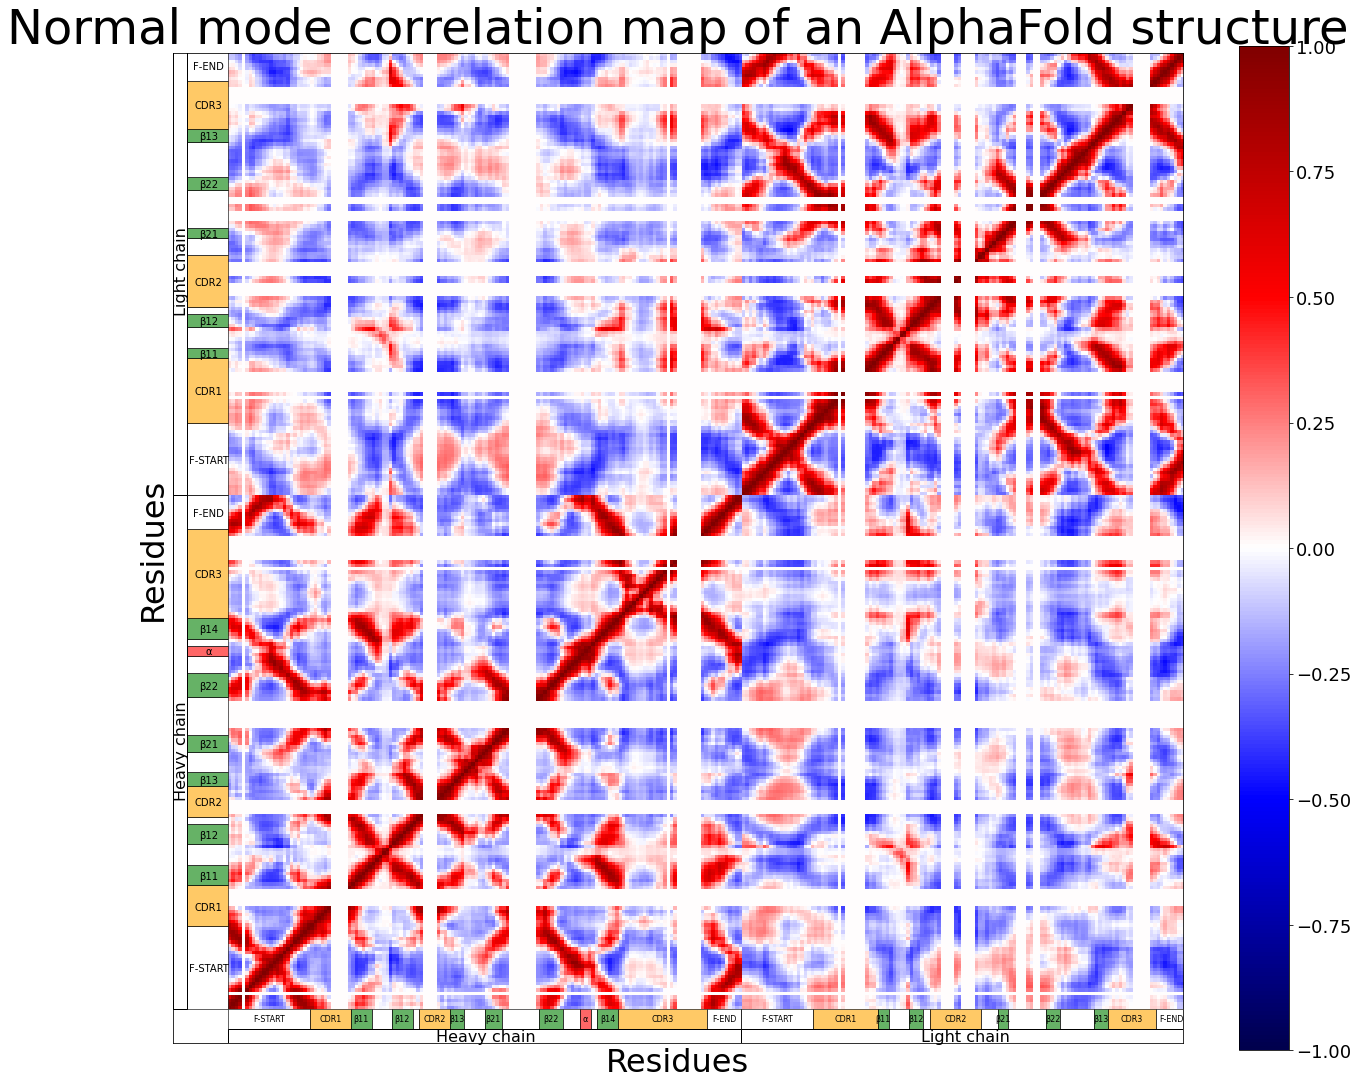

In [3]:
plot_map_with_regions(preprocessed_data, preprocessed_data.test_x, title='Normal mode correlation map of an AlphaFold structure')

# Loading an ANTIPASTI checkpoint

In [4]:
path = '../checkpoints/model_' + regions + '_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model = load_checkpoint(path, input_shape)[0]
model.eval()

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 2, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=154568, out_features=1, bias=False)
)

# Predicting the binding affinity

In [5]:
# We convert to the torch format and predict
kds_original = [model(torch.from_numpy(test_arr.reshape(1, 1, input_shape, input_shape).astype(np.float32)))[0].detach().numpy()[0,0] for test_arr in original_structures]
kds_af_pred = [model(torch.from_numpy(test_arr.reshape(1, 1, input_shape, input_shape).astype(np.float32)))[0].detach().numpy()[0,0] for test_arr in af_pred_structures]
corr_coeff = np.corrcoef(kds_original, kds_af_pred)[1,0]

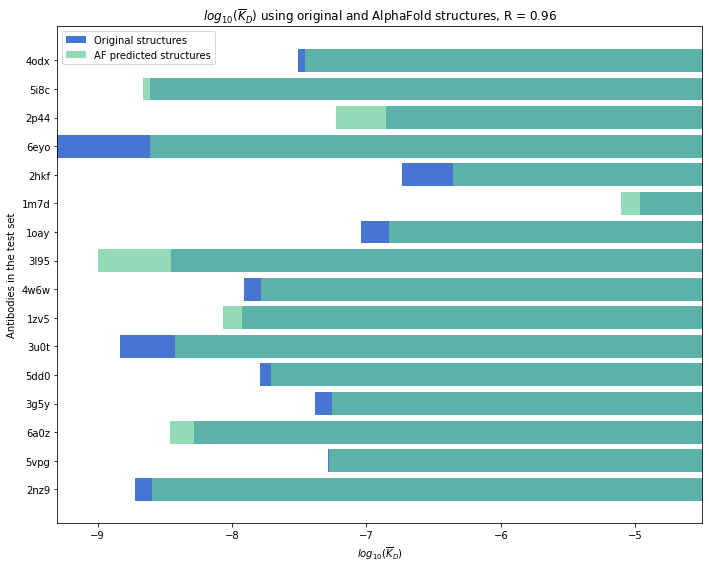

In [6]:
# Horizontal bar chart
fig = plt.figure(figsize=(10, 8))
y_pos = np.arange(len(test_pdbs))
plt.barh(y_pos, kds_original, align='center', alpha=0.9, label='Original structures', color='#3366cc')
plt.barh(y_pos, kds_af_pred, align='center', alpha=0.7, label='AF predicted structures', color='#66cc99')

# Add labels, title, and legend
plt.xlabel('$log_{10}(\overline{K}_D)$')
plt.ylabel('Antibodies in the test set')
plt.title('$log_{10}(\overline{K}_D)$ using original and AlphaFold structures, R = '+str(round(corr_coeff, 2)))
plt.yticks(y_pos, test_pdbs)
plt.legend()
plt.tight_layout()

# x-axis going from the minimum to -4.5
min_kd = min(min(kds_original), min(kds_af_pred))
plt.xlim(min_kd, -4.5)

plt.show()

In [7]:
# Difference of log10(Kd) from original structures and AlphaFold predictions
kds_difference = np.array([kds_original[i] - kds_af_pred[i] for i in range(len(kds_original))])

# pTM score - Values displayed here but not used
af_ptm = np.array([0.95, 0.94, 0.93, 0.94, 0.94, 0.92, 0.88, 0.90, 0.94, 0.94, 0.94, 0.94, 0.93, 0.90, 0.93, 0.94])

# Maximum alignment error (MAE)
af_max_mae = np.array([20.19, 21.88, 23.05, 23.67, 23.58, 24.98, 19.16, 23.5, 24.47, 22.92, 20.52, 22.94, 27.11, 17.33, 17.50, 23.22])

# Predicted local distance difference test (pLDDT), i.e., per-residue confidence
# Average of the 10 lowest elements
af_plddt = np.array([92.89, 89.57, 72.32, 90.27, 83.10, 72.56, 83.63, 86.99, 76.23, 83.27, 86.21, 78.74, 73.16, 88.66, 84.71, 76.46])

# Resolution reported in Angstroms - Values displayed here but not used
resolution = np.array([3.79, 1.95, 2.33, 1.59, 2.49, 2.50, 2.00, 2.51, 2.19, 2.66, 2.30, 2.01, 3.70, 1.80, 1.52, 3.10])

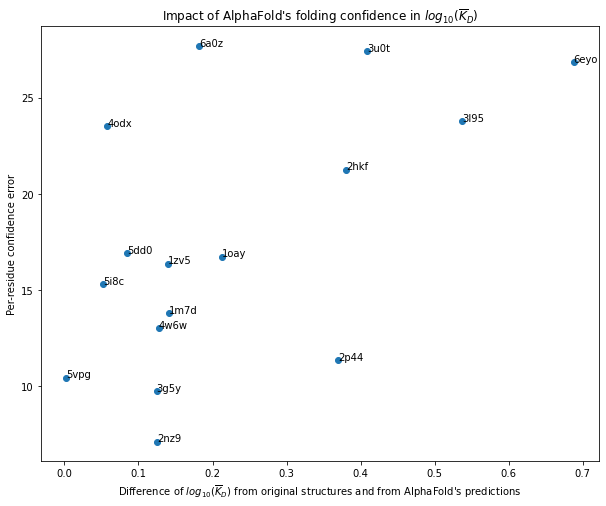

In [8]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), 100-af_plddt)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Per-residue confidence error')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), 100-af_plddt[i]))

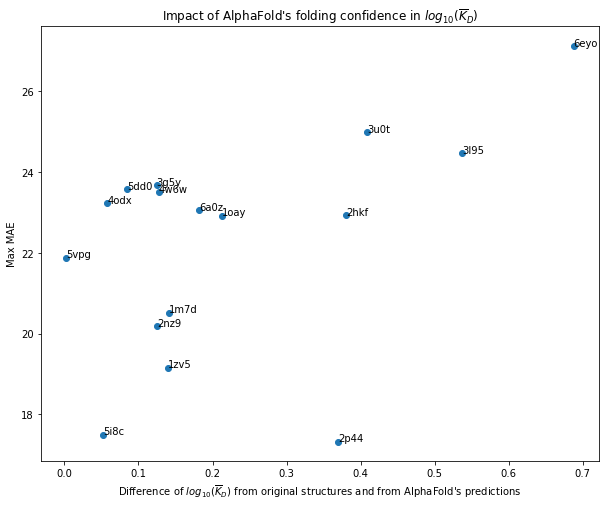

In [9]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(np.abs(kds_difference), af_max_mae)
plt.title('Impact of AlphaFold\'s folding confidence in $log_{10}(\overline{K}_D)$')
plt.xlabel('Difference of $log_{10}(\overline{K}_D)$ from original structures and from AlphaFold\'s predictions')
plt.ylabel('Max MAE')

for i, txt in enumerate(test_pdbs):
    plt.annotate(txt, (np.abs(kds_difference[i]), af_max_mae[i]))